In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# evaluate linear algorithms
from numpy import load
from numpy import loadtxt
from numpy import nan
from numpy import isnan
from numpy import count_nonzero
from numpy import unique
from numpy import array
from sklearn.base import clone
from scipy.stats import sem
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

import os
import pandas as pd
import glob
import math
import datetime
import time
import numpy as np
import scipy
import random

random.seed(10)

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out-1
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [3]:
def convert_to_preferred_format(sec):
    sec = sec % (24 * 3600)
    hour = sec // 3600
    sec %= 3600
    min = sec // 60
    sec %= 60
#  print("seconds value in hours:",hour)
#  print("seconds value in minutes:",min)

#return "%02d:%02d:%02d" % (hour, min, sec) 
    return "%02d:%02d" % (hour, min) 

In [4]:
merged_data = '/content/drive/MyDrive/NHANCE data analysis/NonNormalizedMergedData10min'
merged_files = os.listdir(merged_data)

In [ ]:
data_1min_personalized = pd.DataFrame()


In [ ]:
#@title Default title text
#sampling at 1 minute. Hence predicting, 1, 2 and 3 minutes into future
all_err_lr_1 = []
all_err_svr_1 = []
all_err_gbr_1 = []
all_err_rf_1 = []

for el in merged_files:
  os.chdir(merged_data)
  data = pd.read_csv(el)
  # data.drop(['Unnamed: 0','Times'], axis = 1, inplace = True)
  data.drop(['Unnamed: 0','time_stamp','Fatigue Perception'], axis = 1, inplace = True)
  data['Times'] =  pd.to_datetime(data['Times'])
  data = data.set_index(['Times'])
  data_1 = data.resample('1min').mean()
  cols = list(data_1.columns)
  cols = cols[1:]
  data_1 = data_1[cols]

  n_timesteps_in = 3 
  n_timesteps_out = 3

  # convert dataset into input/output
  X, y = split_sequences(data_1.values, n_timesteps_in, n_timesteps_out)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle= True)
  
  # convert 3D array into 2D
  X_train = X_train.reshape((X_train.shape[0],X_train.shape[1]*X_train.shape[2]))
  X_test = X_test.reshape((X_test.shape[0],X_test.shape[1]*X_test.shape[2]))

  model_linreg = Ridge()
  model_linreg.fit(X_train, y_train)
  y_predict_lr = model_linreg.predict(X_test)

  abs_err_lr = abs(y_predict_lr - y_test)
  all_err_lr_1.append(abs_err_lr.mean(axis = 0))

  model_svr = MultiOutputRegressor(SVR())
  model_svr.fit(X_train, y_train)
  y_predict_svr = model_svr.predict(X_test)

  abs_err_svr = abs(y_predict_svr - y_test)
  all_err_svr_1.append(abs_err_svr.mean(axis = 0))

  model_gbr = MultiOutputRegressor(GradientBoostingRegressor())
  model_gbr.fit(X_train, y_train)
  y_predict_gbr = model_gbr.predict(X_test)

  abs_err_gbr = abs(y_predict_gbr - y_test)
  all_err_gbr_1.append(abs_err_gbr.mean(axis = 0))

  model_rf = MultiOutputRegressor(RandomForestRegressor(n_estimators=10))
  model_rf.fit(X_train, y_train)
  y_predict_rf = model_rf.predict(X_test)

  abs_err_rf = abs(y_predict_rf - y_test)
  all_err_rf_1.append(abs_err_rf.mean(axis = 0))


error_values_lr = np.asarray(all_err_lr_1)
mean_error_lr = error_values_lr.mean(axis = 0)
#std_error_lr = 1/np.sqrt(31)*error_values_lr.std(axis = 0)
std_error_lr = scipy.stats.sem(error_values_lr, axis=0, ddof=0, nan_policy='propagate')

print('-------------------------------------')
print('Ridge Regression')
print('MAE and STD error for Performance Labels')
print(mean_error_lr)
print(std_error_lr)
print('-------------------------------------')

error_values_svr = np.asarray(all_err_svr_1)
mean_error_svr = error_values_svr.mean(axis = 0)
#std_error_svr = 1/np.sqrt(31)*error_values_svr.std(axis = 0)
std_error_svr = scipy.stats.sem(error_values_svr, axis=0, ddof=0, nan_policy='propagate')

print('-------------------------------------')
print('Support Vector Regression')
print('MAE and STD error for Performance Labels')
print(mean_error_svr)
print(std_error_svr)
print('-------------------------------------')

error_values_gbr = np.asarray(all_err_gbr_1)
mean_error_gbr = error_values_gbr.mean(axis = 0)
#std_error_gbr = 1/np.sqrt(31)*error_values_gbr.std(axis = 0)
std_error_gbr = scipy.stats.sem(error_values_gbr, axis=0, ddof=0, nan_policy='propagate')

print('-------------------------------------')
print('Gradient Boosting Regression')
print('MAE and STD error for Performance Labels')
print(mean_error_gbr)
print(std_error_gbr)
print('-------------------------------------')


error_values_rf = np.asarray(all_err_rf_1)
mean_error_rf = error_values_rf.mean(axis = 0)
#std_error_rf = 1/np.sqrt(31)*error_values_rf.std(axis = 0)
std_error_rf = scipy.stats.sem(error_values_rf, axis=0, ddof=0, nan_policy='propagate')

print('-------------------------------------')
print('Random Forest Regression')
print('MAE and STD error for Performance Labels')
print(mean_error_rf)
print(std_error_rf)
print('-------------------------------------')

perf = pd.DataFrame(np.stack((mean_error_lr, mean_error_svr, mean_error_gbr, mean_error_rf), axis = 0))
perf_std_ = pd.DataFrame(np.stack((std_error_lr, std_error_svr, std_error_gbr, std_error_rf), axis = 0))

x_lr = perf.iloc[0]
x_svr = perf.iloc[1]
x_gbr = perf.iloc[2]
x_rf = perf.iloc[3]
actual_x = ['t','t+Δt','t+2Δt']
plt.title("Personalized performance model for 1 minute predictions")
plt.plot(actual_x, x_lr, label = "lr")
plt.plot(actual_x, x_svr, label = "svr")
plt.plot(actual_x, x_gbr, label = "gbr")
plt.plot(actual_x, x_rf, label = "rf")

plt.errorbar(actual_x, x_lr, yerr = perf_std_.iloc[0], fmt = 'o')
plt.errorbar(actual_x, x_svr, yerr = perf_std_.iloc[1], fmt = 'o')
plt.errorbar(actual_x, x_gbr, yerr = perf_std_.iloc[2], fmt = 'o')
plt.errorbar(actual_x, x_rf, yerr = perf_std_.iloc[3], fmt = 'o')

plt.legend(loc="upper right")
#plt.ylim(0.01,0.07)
#plt.xlim('t','t+Δt','t+2Δt')
plt.show()

In [ ]:
#@title Default title text
#sampling at 5 minutes. Hence predicting 5, 10 and 15 minutes into future

all_err_lr_2 = []
all_err_svr_2 = []
all_err_gbr_2 = []
all_err_rf_2 = []

for el in merged_files:
  os.chdir(merged_data)
  data = pd.read_csv(el)
  data.drop(['Unnamed: 0','time_stamp','Fatigue Perception'], axis = 1, inplace = True)
  data['Times'] =  pd.to_datetime(data['Times'])
  data = data.set_index(['Times'])
  data_1 = data.resample('5min').mean()
  cols = list(data_1.columns)
  cols = cols[1:]
  data_1 = data_1[cols]

  n_timesteps_in = 3 
  n_timesteps_out = 3

  # convert dataset into input/output
  X, y = split_sequences(data_1.values, n_timesteps_in, n_timesteps_out)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle= True)
  
  # convert 3D array into 2D
  X_train = X_train.reshape((X_train.shape[0],X_train.shape[1]*X_train.shape[2]))
  X_test = X_test.reshape((X_test.shape[0],X_test.shape[1]*X_test.shape[2]))

  model_linreg = Ridge()
  model_linreg.fit(X_train, y_train)
  y_predict_lr = model_linreg.predict(X_test)

  abs_err_lr = abs(y_predict_lr - y_test)
  all_err_lr_2.append(abs_err_lr.mean(axis = 0))

  model_svr = MultiOutputRegressor(SVR())
  model_svr.fit(X_train, y_train)
  y_predict_svr = model_svr.predict(X_test)

  abs_err_svr = abs(y_predict_svr - y_test)
  all_err_svr_2.append(abs_err_svr.mean(axis = 0))

  model_gbr = MultiOutputRegressor(GradientBoostingRegressor())
  model_gbr.fit(X_train, y_train)
  y_predict_gbr = model_gbr.predict(X_test)

  abs_err_gbr = abs(y_predict_gbr - y_test)
  all_err_gbr_2.append(abs_err_gbr.mean(axis = 0))

  model_rf = MultiOutputRegressor(RandomForestRegressor(n_estimators=10))
  model_rf.fit(X_train, y_train)
  y_predict_rf = model_rf.predict(X_test)

  abs_err_rf = abs(y_predict_rf - y_test)
  all_err_rf_2.append(abs_err_rf.mean(axis = 0))


error_values_lr_2 = np.asarray(all_err_lr_2)
mean_error_lr_2 = error_values_lr_2.mean(axis = 0)
#std_error_lr_2 = 1/np.sqrt(31)*error_values_lr_2.std(axis = 0)
std_error_lr_2 = scipy.stats.sem(error_values_lr_2 , axis=0, ddof=0, nan_policy='propagate')

print('-------------------------------------')
print('Ridge Regression')
print('MAE and STD error for Performance Labels')
print(mean_error_lr_2)
print(std_error_lr_2)
print('-------------------------------------')

error_values_svr_2 = np.asarray(all_err_svr_2)
mean_error_svr_2 = error_values_svr_2.mean(axis = 0)
#std_error_svr_2 = 1/np.sqrt(31)*error_values_svr_2.std(axis = 0)
std_error_svr_2 = scipy.stats.sem(error_values_svr_2 , axis=0, ddof=0, nan_policy='propagate')

print('-------------------------------------')
print('Support Vector Regression')
print('MAE and STD error for Performance Labels')
print(mean_error_svr_2)
print(std_error_svr_2)
print('-------------------------------------')

error_values_gbr_2 = np.asarray(all_err_gbr_2)
mean_error_gbr_2 = error_values_gbr_2.mean(axis = 0)
#std_error_gbr_2 = 1/np.sqrt(31)*error_values_gbr_2.std(axis = 0)
std_error_gbr_2 = scipy.stats.sem(error_values_gbr_2 , axis=0, ddof=0, nan_policy='propagate')

print('-------------------------------------')
print('Gradient Boosting Regression')
print('MAE and STD error for Performance Labels')
print(mean_error_gbr_2)
print(std_error_gbr_2)
print('-------------------------------------')


error_values_rf_2 = np.asarray(all_err_rf_2)
mean_error_rf_2 = error_values_rf_2.mean(axis = 0)
#std_error_rf_2 = 1/np.sqrt(31)*error_values_rf_2.std(axis = 0)
std_error_rf_2 = scipy.stats.sem(error_values_rf_2 , axis=0, ddof=0, nan_policy='propagate')

print('-------------------------------------')
print('Random Forest Regression')
print('MAE and STD error for Performance Labels')
print(mean_error_rf_2)
print(std_error_rf_2)
print('-------------------------------------')

perf_2 = pd.DataFrame(np.stack((mean_error_lr_2, mean_error_svr_2, mean_error_gbr_2, mean_error_rf_2), axis = 0))
perf_std_2 = pd.DataFrame(np.stack((std_error_lr_2, std_error_svr_2, std_error_gbr_2, std_error_rf_2), axis = 0))


x_lr_2 = perf_2.iloc[0]
x_svr_2 = perf_2.iloc[1]
x_gbr_2 = perf_2.iloc[2]
x_rf_2 = perf_2.iloc[3]
plt.title("Personalized performance model for 5 minute predictions")
actual_x = ['t','t+Δt','t+2Δt']
plt.plot(actual_x, x_lr_2, label = "lr")
plt.plot(actual_x, x_svr_2, label = "svr")
plt.plot(actual_x, x_gbr_2, label = "gbr")
plt.plot(actual_x, x_rf_2, label = "rf")

plt.errorbar(actual_x, x_lr_2, yerr = perf_std_2.iloc[0], fmt = 'o')
plt.errorbar(actual_x, x_svr_2, yerr = perf_std_2.iloc[1], fmt = 'o')
plt.errorbar(actual_x, x_gbr_2, yerr = perf_std_2.iloc[2], fmt = 'o')
plt.errorbar(actual_x, x_rf_2, yerr = perf_std_2.iloc[3], fmt = 'o')

plt.legend(loc="upper right")
plt.show()

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


-------------------------------------
Ridge Regression
MAE and STD error for Performance Labels
[0.02286371 0.01915862 0.02129868]
[0.01005837 0.00603026 0.00818898]
-------------------------------------
-------------------------------------
Support Vector Regression
MAE and STD error for Performance Labels
[0.01221808 0.01387516 0.0117732 ]
[0.00236018 0.00341844 0.00160382]
-------------------------------------
-------------------------------------
Gradient Boosting Regression
MAE and STD error for Performance Labels
[0.01144079 0.01466387 0.01141869]
[0.0022093  0.0030884  0.00170813]
-------------------------------------
-------------------------------------
Random Forest Regression
MAE and STD error for Performance Labels
[0.01220496 0.01266523 0.01118016]
[0.00294559 0.0034539  0.00141073]
-------------------------------------


<ipython-input-5-fc77eeb50b6e>:134: MatplotlibDeprecationWarning: Unrecognized location 'bottom'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  plt.legend(bbox_to_anchor=(1.02, 1), loc='bottom', borderaxespad=0)


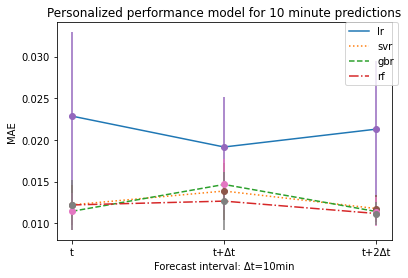

In [5]:
#sampling at 10 minutes. Hence predicting, 10, 20 and 30 minutes into future
random.seed(10)

n_timesteps_in = 3 
n_timesteps_out = 3 
all_err_lr_3 = []
all_err_svr_3 = []
all_err_gbr_3 = []
all_err_rf_3 = []

for el in merged_files:
  os.chdir(merged_data)
  data = pd.read_csv(el)
  data.drop(['Unnamed: 0','time_stamp','Fatigue Perception'], axis = 1, inplace = True)
  data['Times'] =  pd.to_datetime(data['Times'])
  data = data.set_index(['Times'])
  data_1 = data.resample('10min').mean()
  cols = list(data_1.columns)
  cols = cols[1:]
  data_1 = data_1[cols]

  n_timesteps_in = 3 
  n_timesteps_out = 3

  # convert dataset into input/output
  X, y = split_sequences(data_1.values, n_timesteps_in, n_timesteps_out)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle= True)
  
  # convert 3D array into 2D
  X_train = X_train.reshape((X_train.shape[0],X_train.shape[1]*X_train.shape[2]))
  X_test = X_test.reshape((X_test.shape[0],X_test.shape[1]*X_test.shape[2]))

  model_linreg = Ridge()
  model_linreg.fit(X_train, y_train)
  y_predict_lr = model_linreg.predict(X_test)

  abs_err_lr = abs(y_predict_lr - y_test)
  all_err_lr_3.append(abs_err_lr.mean(axis = 0))

  model_svr = MultiOutputRegressor(SVR())
  model_svr.fit(X_train, y_train)
  y_predict_svr = model_svr.predict(X_test)

  abs_err_svr = abs(y_predict_svr - y_test)
  all_err_svr_3.append(abs_err_svr.mean(axis = 0))

  model_gbr = MultiOutputRegressor(GradientBoostingRegressor())
  model_gbr.fit(X_train, y_train)
  y_predict_gbr = model_gbr.predict(X_test)

  abs_err_gbr = abs(y_predict_gbr - y_test)
  all_err_gbr_3.append(abs_err_gbr.mean(axis = 0))

  model_rf = MultiOutputRegressor(RandomForestRegressor(n_estimators=10))
  model_rf.fit(X_train, y_train)
  y_predict_rf = model_rf.predict(X_test)

  abs_err_rf = abs(y_predict_rf - y_test)
  all_err_rf_3.append(abs_err_rf.mean(axis = 0))


error_values_lr_3 = np.asarray(all_err_lr_3)
mean_error_lr_3 = error_values_lr_3.mean(axis = 0)
#std_error_lr_3 = 1/np.sqrt(31)*error_values_lr_3.std(axis = 0)
std_error_lr_3 = scipy.stats.sem(error_values_lr_3 , axis=0, ddof=0, nan_policy='propagate')

print('-------------------------------------')
print('Ridge Regression')
print('MAE and STD error for Performance Labels')
print(mean_error_lr_3)
print(std_error_lr_3)
print('-------------------------------------')

error_values_svr_3 = np.asarray(all_err_svr_3)
mean_error_svr_3 = error_values_svr_3.mean(axis = 0)
#std_error_svr_3 = 1/np.sqrt(31)*error_values_svr_3.std(axis = 0)
std_error_svr_3 = scipy.stats.sem(error_values_svr_3 , axis=0, ddof=0, nan_policy='propagate')

print('-------------------------------------')
print('Support Vector Regression')
print('MAE and STD error for Performance Labels')
print(mean_error_svr_3)
print(std_error_svr_3)
print('-------------------------------------')

error_values_gbr_3 = np.asarray(all_err_gbr_3)
mean_error_gbr_3 = error_values_gbr_3.mean(axis = 0)
#std_error_gbr_3 = 1/np.sqrt(31)*error_values_gbr_3.std(axis = 0)
std_error_gbr_3 = scipy.stats.sem(error_values_gbr_3 , axis=0, ddof=0, nan_policy='propagate')

print('-------------------------------------')
print('Gradient Boosting Regression')
print('MAE and STD error for Performance Labels')
print(mean_error_gbr_3)
print(std_error_gbr_3)
print('-------------------------------------')


error_values_rf_3 = np.asarray(all_err_rf_3)
mean_error_rf_3 = error_values_rf_3.mean(axis = 0)
#std_error_rf_3 = 1/np.sqrt(31)*error_values_rf_3.std(axis = 0)
std_error_rf_3 = scipy.stats.sem(error_values_rf_3 , axis=0, ddof=0, nan_policy='propagate')

print('-------------------------------------')
print('Random Forest Regression')
print('MAE and STD error for Performance Labels')
print(mean_error_rf_3)
print(std_error_rf_3)
print('-------------------------------------')

perf_3 = pd.DataFrame(np.stack((mean_error_lr_3, mean_error_svr_3, mean_error_gbr_3, mean_error_rf_3), axis = 0))
perf_std_3 = pd.DataFrame(np.stack((std_error_lr_3, std_error_svr_3, std_error_gbr_3, std_error_rf_3), axis = 0))

x_lr_3 = perf_3.iloc[0]
x_svr_3 = perf_3.iloc[1]
x_gbr_3 = perf_3.iloc[2]
x_rf_3 = perf_3.iloc[3]
actual_x = ['t','t+Δt','t+2Δt']
plt.title("Personalized performance model for 10 minute predictions")
plt.ylabel("Mean absolute error")
plt.plot(actual_x, x_lr_3, label = "lr", linestyle = 'solid')
plt.plot(actual_x, x_svr_3, label = "svr", linestyle = 'dotted')
plt.plot(actual_x, x_gbr_3, label = "gbr", linestyle = 'dashed')
plt.plot(actual_x, x_rf_3, label = "rf", linestyle = 'dashdot')

plt.errorbar(actual_x, x_lr_3, yerr = perf_std_3.iloc[0], fmt = 'o')
plt.errorbar(actual_x, x_svr_3, yerr = perf_std_3.iloc[1], fmt = 'o')
plt.errorbar(actual_x, x_gbr_3, yerr = perf_std_3.iloc[2], fmt = 'o')
plt.errorbar(actual_x, x_rf_3, yerr = perf_std_3.iloc[3], fmt = 'o')

#plt.legend(loc="bottom")
plt.ylabel("MAE")
plt.xlabel("Forecast interval: Δt=10min")
plt.legend(bbox_to_anchor=(1.02, 1), loc='bottom', borderaxespad=0)
plt.show()